In [32]:
__author__ = 'Stephanie Juneau, NOAO Data Lab Team'
__version__ = '20171219' # yyyymmdd
__datasets__ = ['des_dr1']  # enter used datasets by hand;
                           # for a list of available datasets, see cell "Available datasets in Data Lab" further below


# Star/Galaxy/QSO Classification in the Dark Energy Survey (DES)
by Stéphanie Juneau, Knut Olsen, Robert Nikutta and the NOAO Data Lab Team

In this notebook, we investigate the optical colors of astronomical sources detected in the Dark Energy Survey (DES), an imaging survey conducted with the Dark Energy Camera (DECam) on the 4-meter Blanco telescope. The first data release, DR1, comprises ~400 millions stars, galaxies and quasars (or QSOs: Quasi-Stellar Objects). 

NOAO Data Lab products and services used here:
<ul>
<li>the DES DR1 database</li>
<li>Jupyter Notebook Server</li>
<li>Query Manager</li>
</ul>

Below, we query the database, compute colors, plot a few color combinations, and take into account the source shapes as defined from the spread of the light profiles and a pre-computed star-galaxy classifier, in order to differentiate between object classes.

### Table of contents
* [0. Disclaimer & attribution](#attribution)
* [1. Introduction](#introduction)
* [2. Imports & setup](#import)
* [3. Authentication](#auth)
* [4. Available Datasets](#datasets)
* [5. Query DES Photometry Catalog](#query)
* [6. Plot Results](#plots)
* [7. Comparison with DES Team Classification](#compare)
* [8. Class_star Comparison](#classstar)
* [9. Resources and references](#resources)

<a class="anchor" id="attribution"></a>
# 0. Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/known-issues.php

<a class="anchor" id="introduction"></a>
# 1. Introduction

An imaging survey includes a zoo of different astronomical objects. There are foreground stars from our own Milky Way galaxies, and background galaxies at various distances, including QSOs (quasi-stellar objects) with actively accreting supermassive black holes. In this Notebook, we aim to distinguish between object classes using combinations of colors and shape parameters.


## 1.1 Magnitudes and Colors

Magnitudes are obtained through a set of filters similar to the *u,g,r,i,z* set used for SDSS. In this work, we use 
*g,r,z* from the Dark Energy Camera (DECam)


Colors are defined as a difference between magnitudes in two bands. A "redder" color means that the object is comparatively brighter in the redder (i.e., longer wavelength) band. Conversely, a "bluer" color means that the object is comparatively brighther in the bluer (i.e., shorter wavelenght) band. 

We will use the following colors: 
<ul>
<li>*g-r*
<li>*r-z*
</ul>

## 1.2 Object Shapes/Types

The object shape (2D light profile) can be defined with a size and ellipticity. In this Notebook, we are interested in distinguishing between stars as point sources, and galaxies as extended sources. 

<ul>
<li> *kron_radius*: Kron radius in pixels 
<li> *spread_model_X*: star-galaxy classifier comparing extended model to PSF model. Value is given for each band X = g, r, i, z, y
<li> *class_star_X*: value ranging from 0.0 (not a star) to 1.0 (star), for each band X = g, r, i, z, y 
</ul>

The value of *spread_model* is near zero for a point source (star or QSO), positive for an extended source (galaxy), negative for an artefact smaller than the PSF (e.g., bad pixel or cosmic ray). More information about the spread_model can be found in Desai et al (2012), and Soumagnac et al (2015).

<a class="anchor" id="import"></a>
# 2. Imports and setup

In [33]:
# Python 2/3 compatibility
from __future__ import print_function # to use print() as a function in Python 2
#from __future__ import division  # if you need Python 3 division behavior in Python 2

try:
    input = raw_input # use 'input' function in both Python 2 and 3
except NameError:
    pass

# std lib
from getpass import getpass
from cStringIO import StringIO  #C script to handle string format

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
%matplotlib inline
from astropy.table import Table

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers

print('Done importing')

Done importing


<a class="anchor" id="auth"></a>
# 3. Authentication

In [34]:
# Python 2/3 compatibility
try:
    input = raw_input
except NameError:
    pass

# Either get token for anonymous user
token = ac.login('anonymous')

# ... or for authenticated user
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))


<a class="anchor" id="datasets"></a>
# 4. Available datasets in Data Lab

In [35]:
# set default profile
qc.set_profile('default')

# these schemas are not astronomical datasets
_remove = set(['ivao','ivao_smash','tap_schema','schema'])

# get all schemas from DB
_schemas = set(qc.query(token,sql='SELECT schema FROM tbl_stat').split())

# remove non-astro schemas
_alldatasets = sorted(list(_schemas - _remove))
print("Datasets available in Data Lab (with current profile):\n", _alldatasets)

# TODO: Enter used datasets by hand in the list __datasets__ in the very first cell above

Datasets available in Data Lab (with current profile):
 [u'allwise', u'dad_dr1', u'decaps_dr1', u'des_sva1', u'gaia_dr1', u'ivoa', u'ivoa_calibrated', u'ivoa_des_dr1', u'ivoa_ls_dr3', u'ivoa_ls_dr4', u'ivoa_ls_dr5', u'ivoa_raw', u'ivoa_smash', u'ls_dr3', u'ls_dr4', u'ls_dr5', u'neo_dr1', u'phat_v2', u'sdss_dr13', u'smash_dr1', u'twomass', u'usno']


<a class="anchor" id="query"></a>
# 5. Query DES Photometry Catalog

The photometry is derived from Tractor modeling of sources, and the database includes model photometry, type (shape), as well as aperture photometry in various aperture sizes. In this work, we will use Tractor model magnitudes.

The database is called **des_dr1** and includes several tables. We will use the **main** table. The column names and descriptions can be found from the [Data Lab Query Interface](http://datalab.noao.edu/query.php) or using the Table Access Protocol (TAP) service with, e.g., TOPCAT. In both cases, we are interested in **des_dr1.main**.

In [36]:
# Before DES public release: set profile to use non-public version of DES
qc.set_profile('des-proto')
print(qc.schema('des_dr1',format='json',profile='des-proto'))


Schema: des_dr1

      Table Name   Description
      ----------   -----------
      complement   Secondary metadata
        exposure   Exposure information
            hpix   HEALPIX tile table
            main   Main object summary table
       neighbors   Objects within 30 arcsec
       tile_info   Tile information table
       galex_des   GALEX crossmatch
         vhs_des   VISTA Hemisphere Survey crossmatch
        wise_des   WISE crossmatch
          band_g   Single-band SExtractor table
          band_i   Single-band SExtractor table
          band_r   Single-band SExtractor table
          band_y   Single-band SExtractor table
          band_z   Single-band SExtractor table
  vac_sextractor   SExtractor summary table



In [37]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, 
               kron_radius, spread_model_g, class_star_g, spread_model_r, class_star_r, 
               spread_model_z, class_star_z, 
               flux_auto_g/fluxerr_auto_g as snr_g2, snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (fluxerr_auto_g>0 and fluxerr_auto_r>0 and fluxerr_auto_z>0)
        LIMIT 300000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# kron_radius        = Kron radius from SExtractor (pixels)
# spread_model_g,r,z = star/galaxy classifier quantifying light profile relative to PSF
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates
#
# WHERE: requirement that error>0 (to avoid dividing by zero) in g,r,z bands
# LIMIT: returns 200,000 rows that satisfy the query

print(query)


        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, 
               kron_radius, spread_model_g, class_star_g, spread_model_r, class_star_r, 
               spread_model_z, class_star_z, 
               flux_auto_g/fluxerr_auto_g as snr_g2, snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (fluxerr_auto_g>0 and fluxerr_auto_r>0 and fluxerr_auto_z>0)
        LIMIT 300000


In [38]:
%%time
# Execute the Query synchronously if short (e.g., LIMIT<=100,000)
response = qc.query(token, sql=query, fmt='csv')

print('Time')

Time
CPU times: user 0 ns, sys: 2.04 s, total: 2.04 s
Wall time: 6.54 s


In [39]:
# Reformat output into a Pandas Data Frame
df = helpers.convert(response,'pandas')
df_all = df

# Print a few rows from the result data frame
print(df[:5])
len(df)

Returning Pandas dataframe
      gmag     rmag     zmag     imag     ymag  kron_radius  spread_model_g  \
0  24.7457  24.3496  24.5474  23.7833  23.6012      4.32806       -0.008115   
1  27.3575  24.3604  23.4932  24.3841  23.8286      6.52358       -0.019655   
2  22.8677  21.9723  21.3760  21.3981  21.1764      4.20977        0.021896   
3  23.6979  23.3906  22.9485  23.2726  23.0515      5.34074        0.011512   
4  22.3260  21.6844  21.5513  21.3052  21.7097      3.75742        0.011902   

   class_star_g  spread_model_r  class_star_r  spread_model_z  class_star_z  \
0      0.541284        0.003748      0.519125       -0.006411      0.424345   
1      0.491976       -0.003869      0.568931        0.009687      0.522207   
2      0.001964        0.018760      0.011841        0.024685      0.006939   
3      0.511435        0.016886      0.519891        0.009984      0.095928   
4      0.019599        0.008170      0.048503        0.014318      0.016932   

      snr_g2      snr_g

300000

<a class="anchor" id="plots"></a>
# 6. Plot Results

## 6.1 Optical Color-Color Diagram

In [40]:
# Select range of interest
thres = 5.   #threshold value for S/N (here, making it more stringent than query)
keep = (df['snr_g']>thres)&(df['snr_r']>thres)&(df['snr_z']>thres)

# Colors
g_r   = df['gmag'][keep] - df['rmag'][keep]
r_z   = df['rmag'][keep] - df['zmag'][keep]

r_i   = df['rmag'][keep] - df['imag'][keep]
i_z   = df['imag'][keep] - df['zmag'][keep]
z_y   = df['zmag'][keep] - df['ymag'][keep]

len(g_r)

# Classification per object type
#objtype = result['type'][keep]

106856

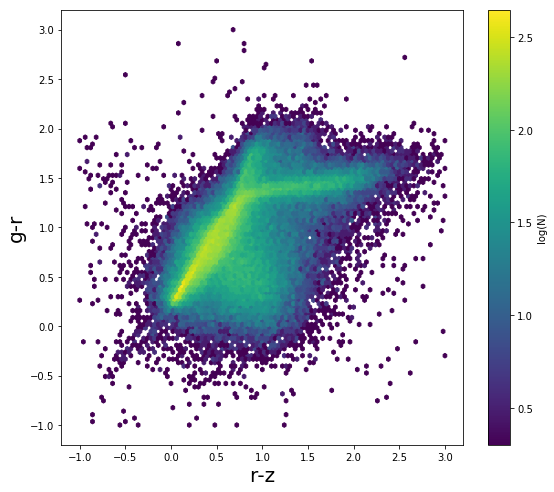

In [41]:
col0 = r_z   #r-z color
col1 = g_r   #g-r color

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
ax1.set_xlabel('r-z',fontsize=20)
ax1.set_ylabel('g-r',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

## 6.2 Morphological Parameters



### g band

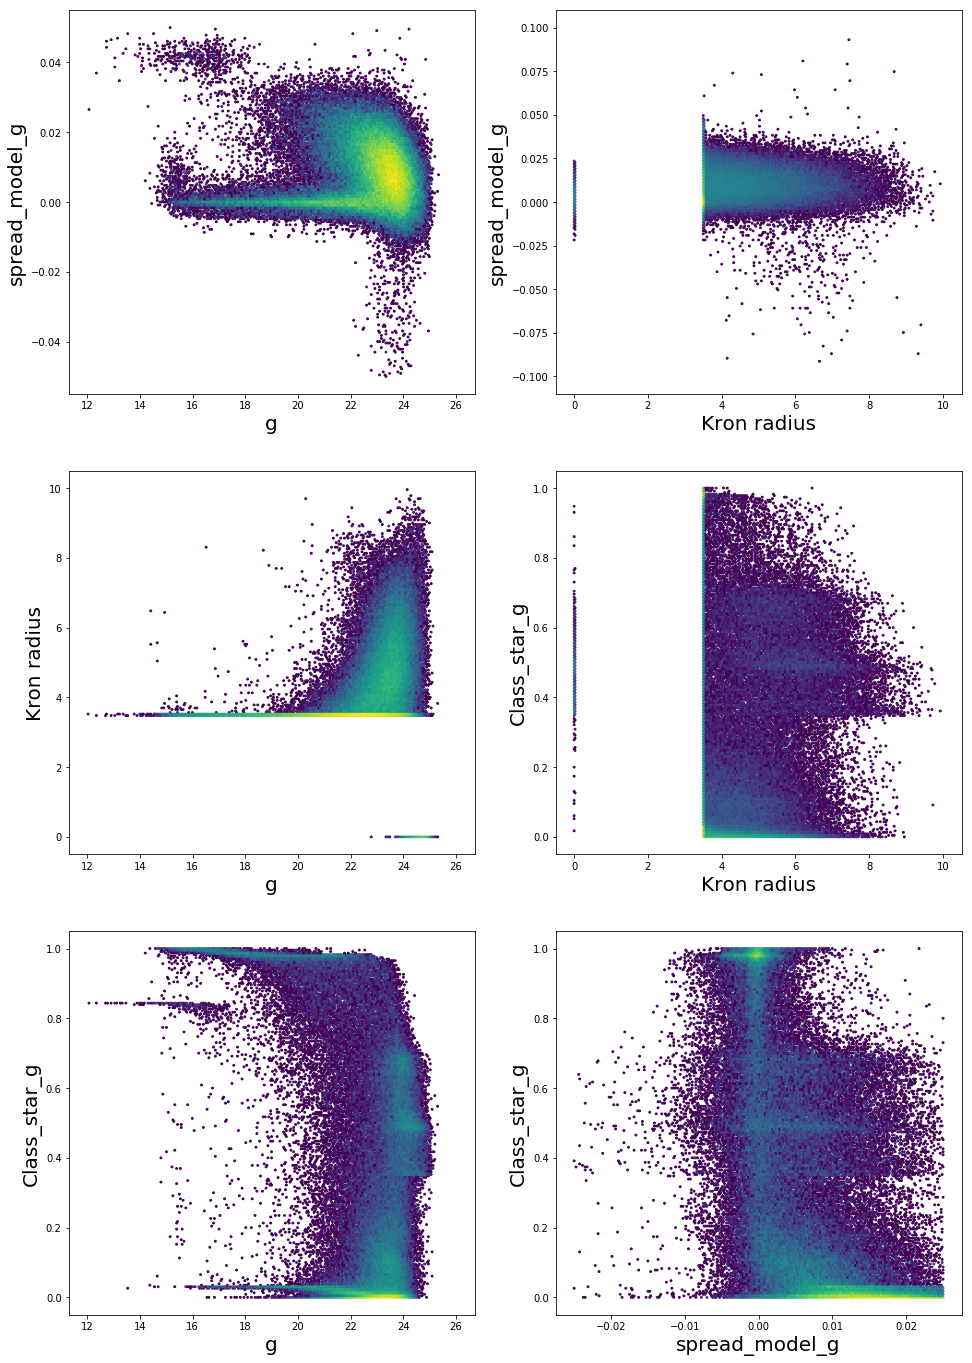

In [42]:
# invalid mags are set to 99 -> mag_auto_X < 90
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the g band
df=df[(df['gmag']<90) & (df['imag']<90) & (df['spread_model_g']>(-1)) & \
      (df['rmag']<90) & (df['zmag']<90) & (df['spread_model_g']<1) & \
      ((df['snr_g'])>5)]

fig = plt.figure(figsize=(8*2,8*3))
ax = fig.add_subplot(3,2,1)
ax.hexbin(df['gmag'],df['spread_model_g'],gridsize=200,bins='log',mincnt=1,extent=(12,26,-0.05,0.05))
ax.set_xlabel('g',fontsize=20)
ax.set_ylabel('spread_model_g',fontsize=20)
ax.tick_params(labelsize=10)

ax2 = fig.add_subplot(3,2,2)
ax2.hexbin(df['kron_radius'],df['spread_model_g'],gridsize=200,bins='log',mincnt=1,extent=(0,10,-0.1,0.1))
ax2.set_xlabel('Kron radius',fontsize=20)
ax2.set_ylabel('spread_model_g',fontsize=20)
ax2.tick_params(labelsize=10)

ax3 = fig.add_subplot(3,2,3)
ax3.hexbin(df['gmag'],df['kron_radius'],gridsize=200,bins='log',mincnt=1,extent=(12,26,0,10))
ax3.set_xlabel('g',fontsize=20)
ax3.set_ylabel('Kron radius',fontsize=20)
ax3.tick_params(labelsize=10)

ax4 = fig.add_subplot(3,2,4)
ax4.hexbin(df['kron_radius'],df['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(0,10,0,1))
ax4.set_xlabel('Kron radius',fontsize=20)
ax4.set_ylabel('Class_star_g',fontsize=20)
ax4.tick_params(labelsize=10)


ax5 = fig.add_subplot(3,2,5)
ax5.hexbin(df['gmag'],df['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(12,26,0,1))
ax5.set_xlabel('g',fontsize=20)
ax5.set_ylabel('Class_star_g',fontsize=20)
ax5.tick_params(labelsize=10)

ax6 = fig.add_subplot(3,2,6)
ax6.hexbin(df['spread_model_g'],df['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(-0.025,0.025,0,1))
ax6.set_xlabel('spread_model_g',fontsize=20)
ax6.set_ylabel('Class_star_g',fontsize=20)
ax6.tick_params(labelsize=10)


### r band

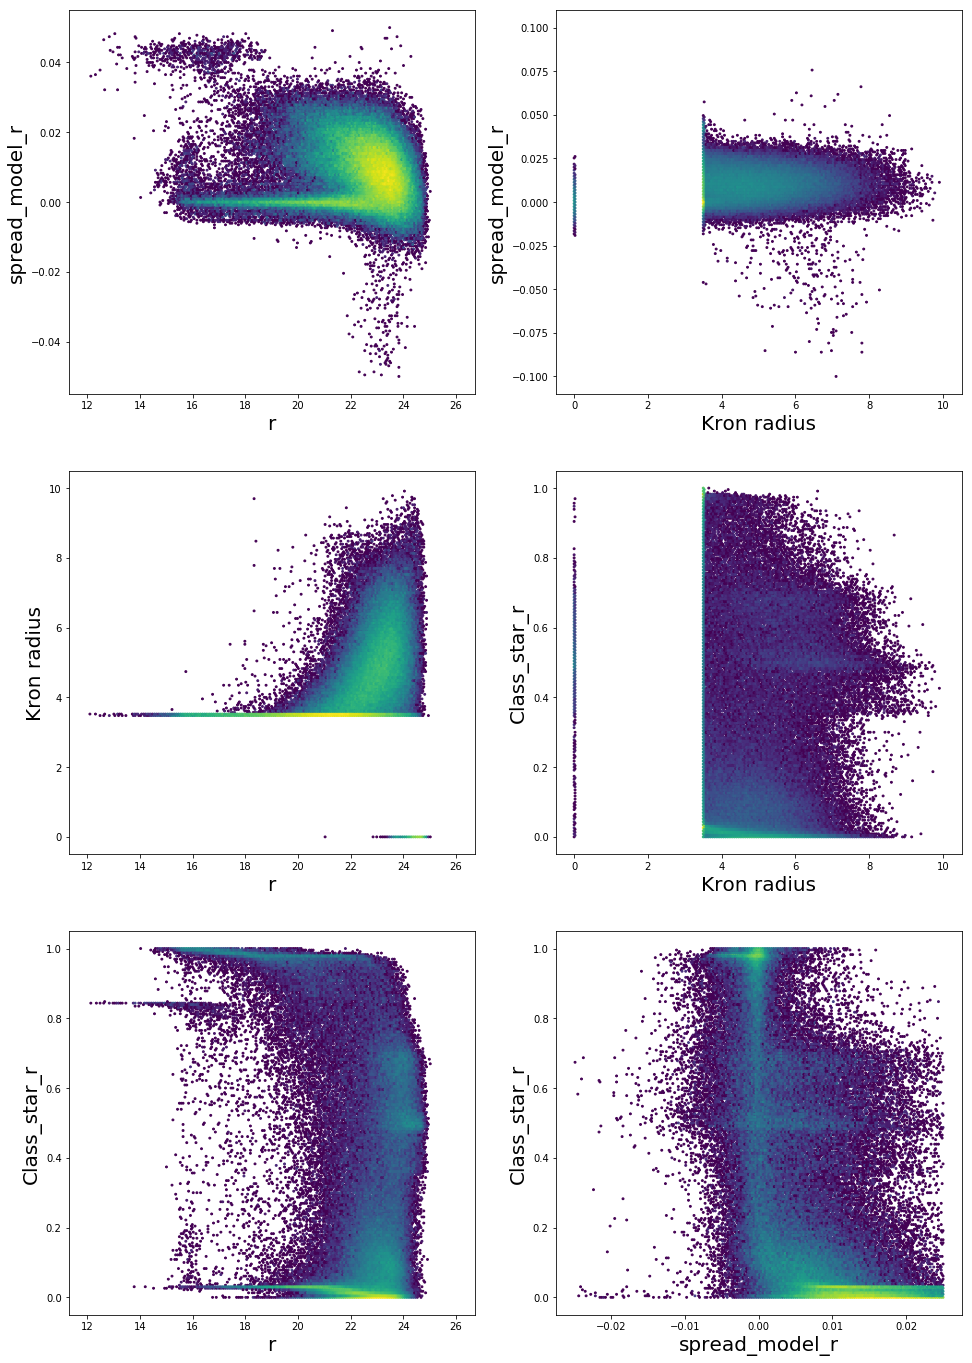

In [43]:
# reset df
df = df_all

# invalid mags are set to 99 -> mag_auto_X < 90
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the r band
df=df[(df['gmag']<90) & (df['imag']<90) & (df['spread_model_r']>(-1)) & \
      (df['rmag']<90) & (df['zmag']<90) & (df['spread_model_r']<1) & \
      ((df['snr_r'])>5)]

fig = plt.figure(figsize=(8*2,8*3))
ax = fig.add_subplot(3,2,1)
ax.hexbin(df['rmag'],df['spread_model_r'],gridsize=200,bins='log',mincnt=1,extent=(12,26,-0.05,0.05))
ax.set_xlabel('r',fontsize=20)
ax.set_ylabel('spread_model_r',fontsize=20)
ax.tick_params(labelsize=10)

ax2 = fig.add_subplot(3,2,2)
ax2.hexbin(df['kron_radius'],df['spread_model_r'],gridsize=200,bins='log',mincnt=1,extent=(0,10,-0.1,0.1))
ax2.set_xlabel('Kron radius',fontsize=20)
ax2.set_ylabel('spread_model_r',fontsize=20)
ax2.tick_params(labelsize=10)

ax3 = fig.add_subplot(3,2,3)
ax3.hexbin(df['rmag'],df['kron_radius'],gridsize=200,bins='log',mincnt=1,extent=(12,26,0,10))
ax3.set_xlabel('r',fontsize=20)
ax3.set_ylabel('Kron radius',fontsize=20)
ax3.tick_params(labelsize=10)

ax4 = fig.add_subplot(3,2,4)
ax4.hexbin(df['kron_radius'],df['class_star_r'],gridsize=200,bins='log',mincnt=1,extent=(0,10,0,1))
ax4.set_xlabel('Kron radius',fontsize=20)
ax4.set_ylabel('Class_star_r',fontsize=20)
ax4.tick_params(labelsize=10)


ax5 = fig.add_subplot(3,2,5)
ax5.hexbin(df['rmag'],df['class_star_r'],gridsize=200,bins='log',mincnt=1,extent=(12,26,0,1))
ax5.set_xlabel('r',fontsize=20)
ax5.set_ylabel('Class_star_r',fontsize=20)
ax5.tick_params(labelsize=10)

ax6 = fig.add_subplot(3,2,6)
ax6.hexbin(df['spread_model_r'],df['class_star_r'],gridsize=200,bins='log',mincnt=1,extent=(-0.025,0.025,0,1))
ax6.set_xlabel('spread_model_r',fontsize=20)
ax6.set_ylabel('Class_star_r',fontsize=20)
ax6.tick_params(labelsize=10)


### z band

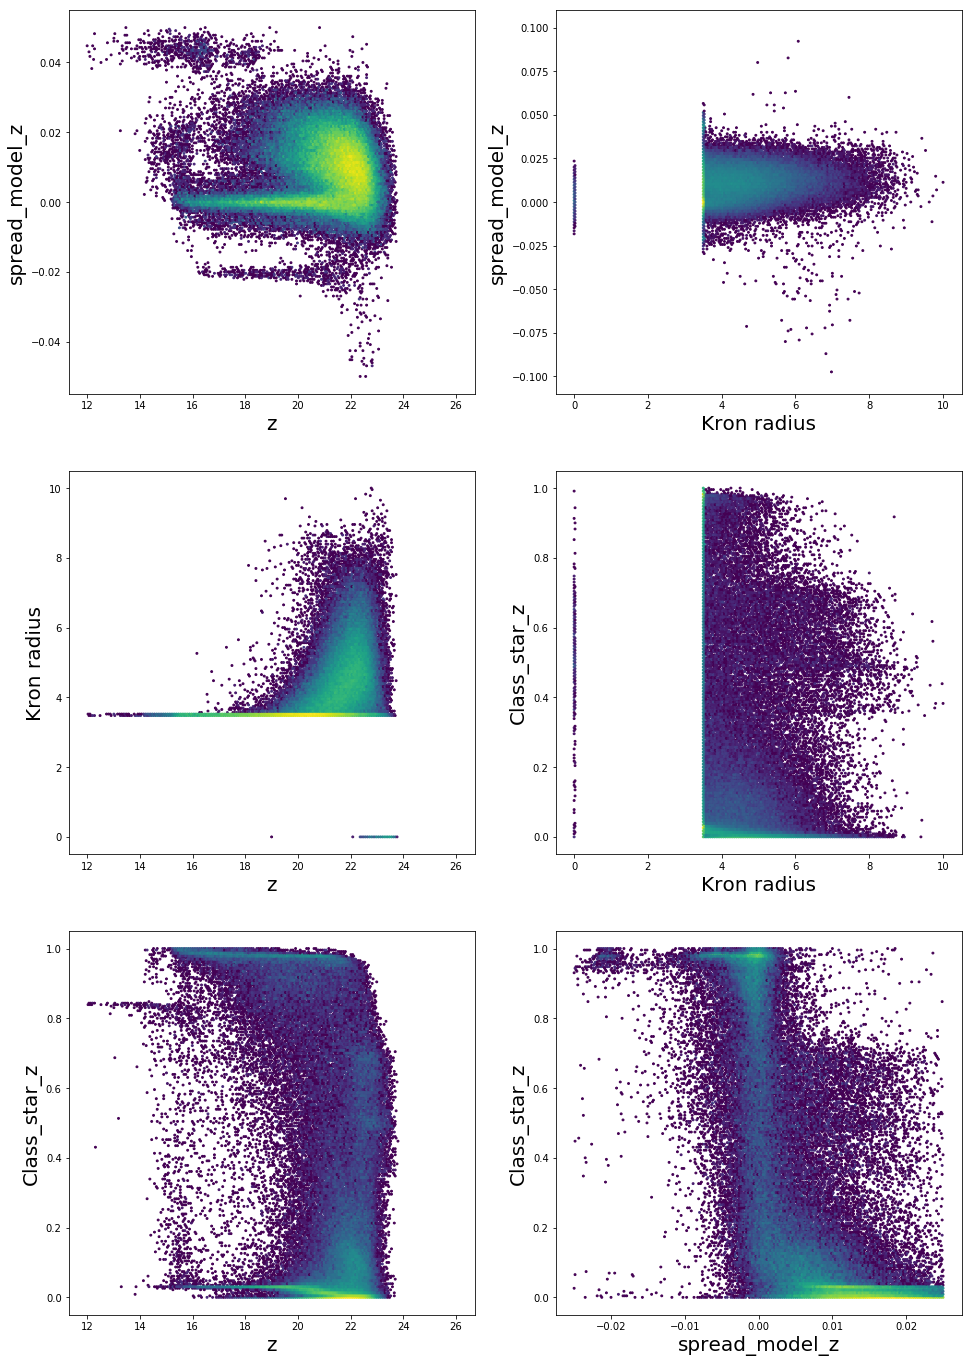

In [44]:
# reset df
df = df_all

# invalid mags are set to 99 -> mag_auto_X < 90
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the z band
df=df[(df['gmag']<90) & (df['imag']<90) & (df['spread_model_z']>(-1)) & \
      (df['rmag']<90) & (df['zmag']<90) & (df['spread_model_z']<1) & \
      ((df['snr_z'])>5)]

fig = plt.figure(figsize=(8*2,8*3))
ax = fig.add_subplot(3,2,1)
ax.hexbin(df['zmag'],df['spread_model_z'],gridsize=200,bins='log',mincnt=1,extent=(12,26,-0.05,0.05))
ax.set_xlabel('z',fontsize=20)
ax.set_ylabel('spread_model_z',fontsize=20)
ax.tick_params(labelsize=10)

ax2 = fig.add_subplot(3,2,2)
ax2.hexbin(df['kron_radius'],df['spread_model_z'],gridsize=200,bins='log',mincnt=1,extent=(0,10,-0.1,0.1))
ax2.set_xlabel('Kron radius',fontsize=20)
ax2.set_ylabel('spread_model_z',fontsize=20)
ax2.tick_params(labelsize=10)

ax3 = fig.add_subplot(3,2,3)
ax3.hexbin(df['zmag'],df['kron_radius'],gridsize=200,bins='log',mincnt=1,extent=(12,26,0,10))
ax3.set_xlabel('z',fontsize=20)
ax3.set_ylabel('Kron radius',fontsize=20)
ax3.tick_params(labelsize=10)

ax4 = fig.add_subplot(3,2,4)
ax4.hexbin(df['kron_radius'],df['class_star_z'],gridsize=200,bins='log',mincnt=1,extent=(0,10,0,1))
ax4.set_xlabel('Kron radius',fontsize=20)
ax4.set_ylabel('Class_star_z',fontsize=20)
ax4.tick_params(labelsize=10)


ax5 = fig.add_subplot(3,2,5)
ax5.hexbin(df['zmag'],df['class_star_z'],gridsize=200,bins='log',mincnt=1,extent=(12,26,0,1))
ax5.set_xlabel('z',fontsize=20)
ax5.set_ylabel('Class_star_z',fontsize=20)
ax5.tick_params(labelsize=10)

ax6 = fig.add_subplot(3,2,6)
ax6.hexbin(df['spread_model_z'],df['class_star_z'],gridsize=200,bins='log',mincnt=1,extent=(-0.025,0.025,0,1))
ax6.set_xlabel('spread_model_z',fontsize=20)
ax6.set_ylabel('Class_star_z',fontsize=20)
ax6.tick_params(labelsize=10)


### Combining bands

Above, the spread_model yields the best separation in the *z* band, as well as the fewest ridge features in distribution of class_star. On the other hand, the *g* band shows the most overlap in spread_model values at faint magnitudes, and the most striking ridges in the distribution of class_star. For testing purposes, let's see what happens for cases that have detections in all 3 g,r,z bands, and then when the classification agrees between the bands.

First, we plot again the "worst" case (*g* band) but requiring objects to have S/N>5 in all of *g,r,z* bands.

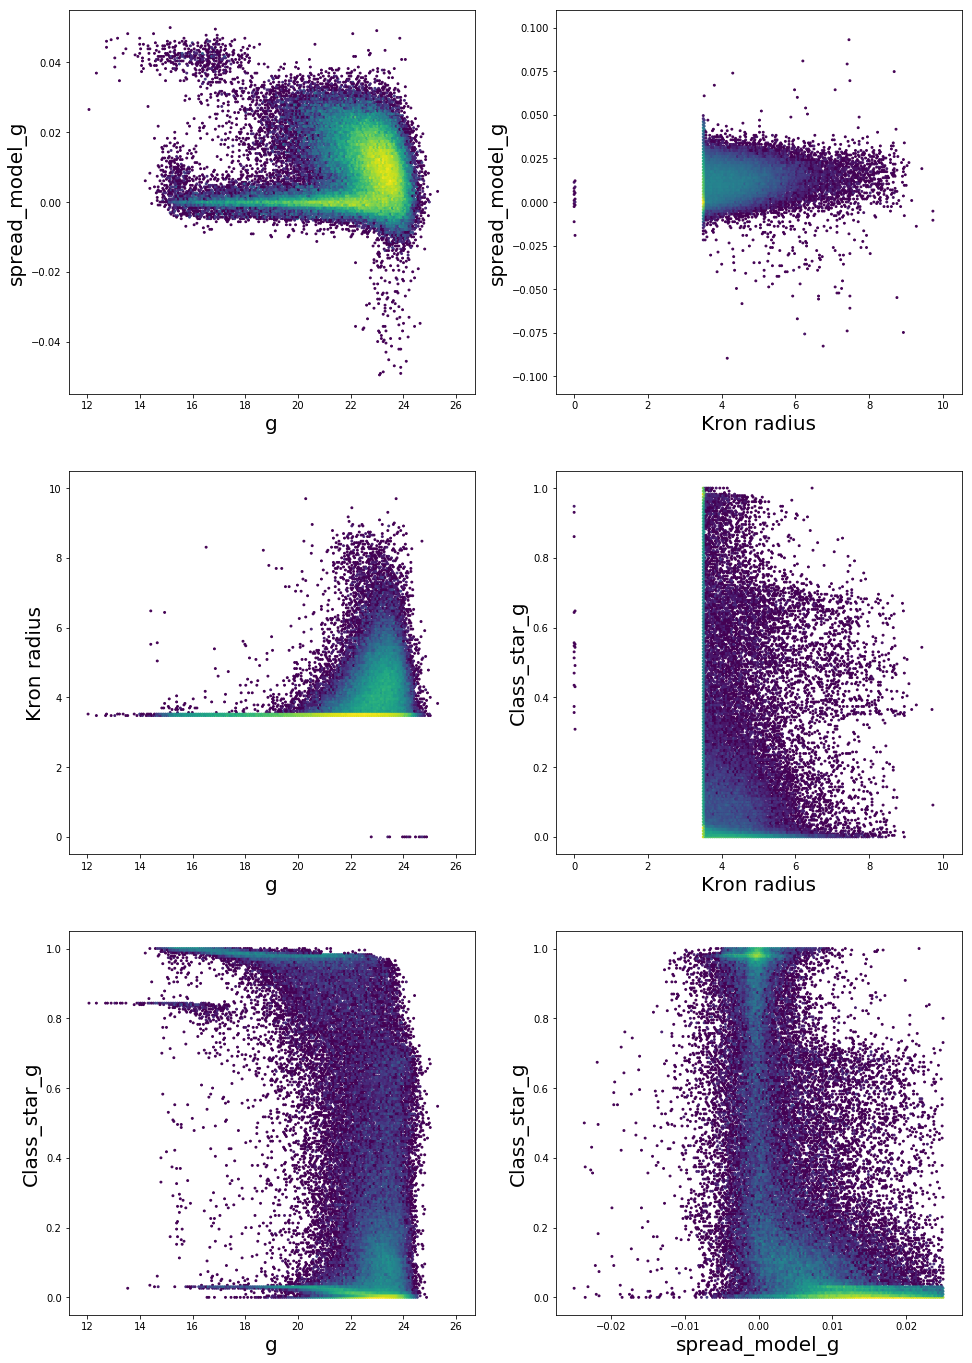

In [45]:
# reset df
df = df_all

# invalid mags are set to 99 but requiring S/N>5 will only keep valid mags
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the g, r, z band
df=df[(df['spread_model_g']>(-1)) & (df['spread_model_g']<1) & \
      (df['snr_g']>5) & (df['snr_r']>5) & (df['snr_z']>5)]

fig = plt.figure(figsize=(8*2,8*3))
ax = fig.add_subplot(3,2,1)
ax.hexbin(df['gmag'],df['spread_model_g'],gridsize=200,bins='log',mincnt=1,extent=(12,26,-0.05,0.05))
ax.set_xlabel('g',fontsize=20)
ax.set_ylabel('spread_model_g',fontsize=20)
ax.tick_params(labelsize=10)

ax2 = fig.add_subplot(3,2,2)
ax2.hexbin(df['kron_radius'],df['spread_model_g'],gridsize=200,bins='log',mincnt=1,extent=(0,10,-0.1,0.1))
ax2.set_xlabel('Kron radius',fontsize=20)
ax2.set_ylabel('spread_model_g',fontsize=20)
ax2.tick_params(labelsize=10)

ax3 = fig.add_subplot(3,2,3)
ax3.hexbin(df['gmag'],df['kron_radius'],gridsize=200,bins='log',mincnt=1,extent=(12,26,0,10))
ax3.set_xlabel('g',fontsize=20)
ax3.set_ylabel('Kron radius',fontsize=20)
ax3.tick_params(labelsize=10)

ax4 = fig.add_subplot(3,2,4)
ax4.hexbin(df['kron_radius'],df['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(0,10,0,1))
ax4.set_xlabel('Kron radius',fontsize=20)
ax4.set_ylabel('Class_star_g',fontsize=20)
ax4.tick_params(labelsize=10)


ax5 = fig.add_subplot(3,2,5)
ax5.hexbin(df['gmag'],df['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(12,26,0,1))
ax5.set_xlabel('g',fontsize=20)
ax5.set_ylabel('Class_star_g',fontsize=20)
ax5.tick_params(labelsize=10)

ax6 = fig.add_subplot(3,2,6)
ax6.hexbin(df['spread_model_g'],df['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(-0.025,0.025,0,1))
ax6.set_xlabel('spread_model_g',fontsize=20)
ax6.set_ylabel('Class_star_g',fontsize=20)
ax6.tick_params(labelsize=10)

The test above resulted in cleaner plots with fewer ridges on the class_star parameter.

Next, let's test what happens in cases with agreement or disagreement of the value of class_star between bands.

In [46]:
def plot_spread_mag(df_input,i,label=None,**kwargs):
    ax = fig.add_subplot(2,2,i+1)
    ax.hexbin(df_input['gmag'],df_input['spread_model_g'],gridsize=200,bins='log',mincnt=1,extent=(12,26,-0.05,0.05))
    ax.set_xlabel('g',fontsize=20)
    ax.set_ylabel('spread_model_g',fontsize=20)
    ax.tick_params(labelsize=10)
    if label is not None:
        ax.text(0.1,0.1,label,transform=ax.transAxes,fontsize=18,color='red',backgroundcolor='white')

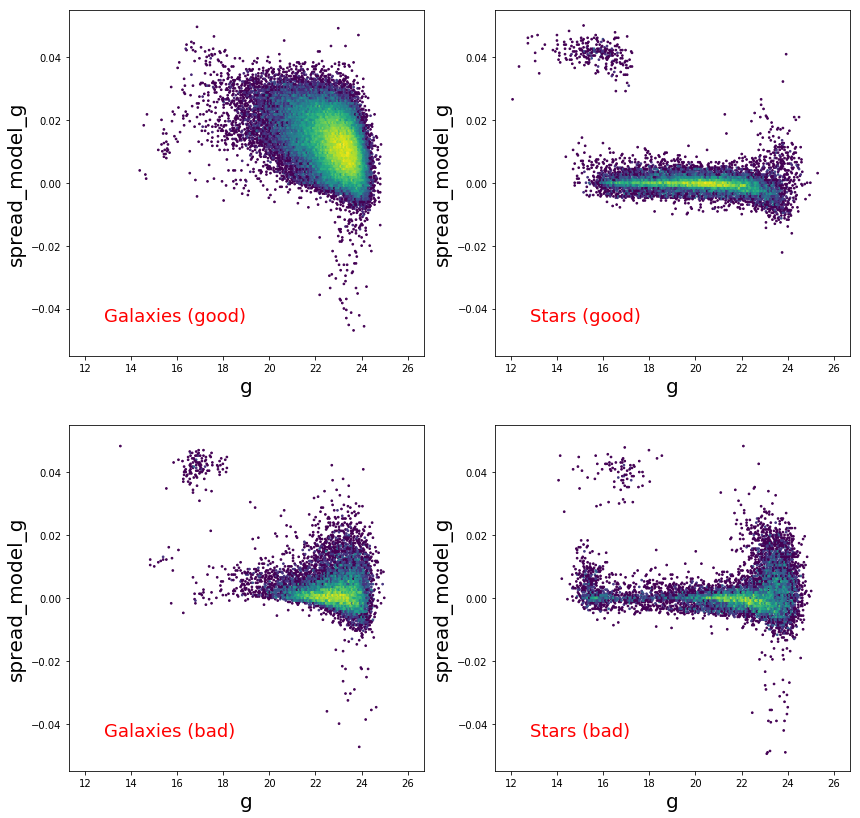

In [47]:
# reset df
df = df_all

# invalid mags are set to 99 -> mag_auto_X < 90
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the g, r, z band
df=df[(df['spread_model_g']>(-1)) & (df['spread_model_g']<1) & \
      (df['snr_g']>5) & (df['snr_r']>5) & (df['snr_z']>5)]

df_gal    = df[(df['class_star_g']<0.5) & (df['class_star_r']<0.5) & (df['class_star_z']<0.5)]
df_notok  = df[(df['class_star_g']<0.5) & ((df['class_star_r']>0.5) | (df['class_star_z']>0.5))]
df_star   = df[(df['class_star_g']>0.5) & (df['class_star_r']>0.5) & (df['class_star_z']>0.5)]
df_notok2 = df[(df['class_star_g']>0.5) & ((df['class_star_r']<0.5) | (df['class_star_z']<0.5))]

fig = plt.figure(figsize=(7*2,7*2))

plot_spread_mag(df_gal,0,label='Galaxies (good)')
plot_spread_mag(df_star,1,label='Stars (good)')
plot_spread_mag(df_notok,2,label='Galaxies (bad)')
plot_spread_mag(df_notok2,3,label='Stars (bad)')

outfile = 'class_star_g_TESTS.png'
fig.savefig(outfile, bbox_inches='tight')

## 6.3 Optical Color-Color Diagram with New Sample Definition

In [48]:
def plot_grz(df_input,i,label=None,**kwargs):
    col0 = df_input['rmag'] - df_input['zmag']   #r-z color
    col1 = df_input['gmag'] - df_input['rmag']   #g-r color
    
    # 2D-histogram of objects
    ax = fig.add_subplot(2,2,i+1)
    ax.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis, gridsize=140, 
               mincnt=1, extent=(-1., 3, -1., 3))
    ax.set_xlabel('r-z',fontsize=20)
    ax.set_ylabel('g-r',fontsize=20)

    if label is not None:
        ax.text(0.1,0.9,label,transform=ax.transAxes,fontsize=16,color='red',backgroundcolor='white')
        
    #color bar
#    cb = plt.colorbar(im1,label='log(N)')

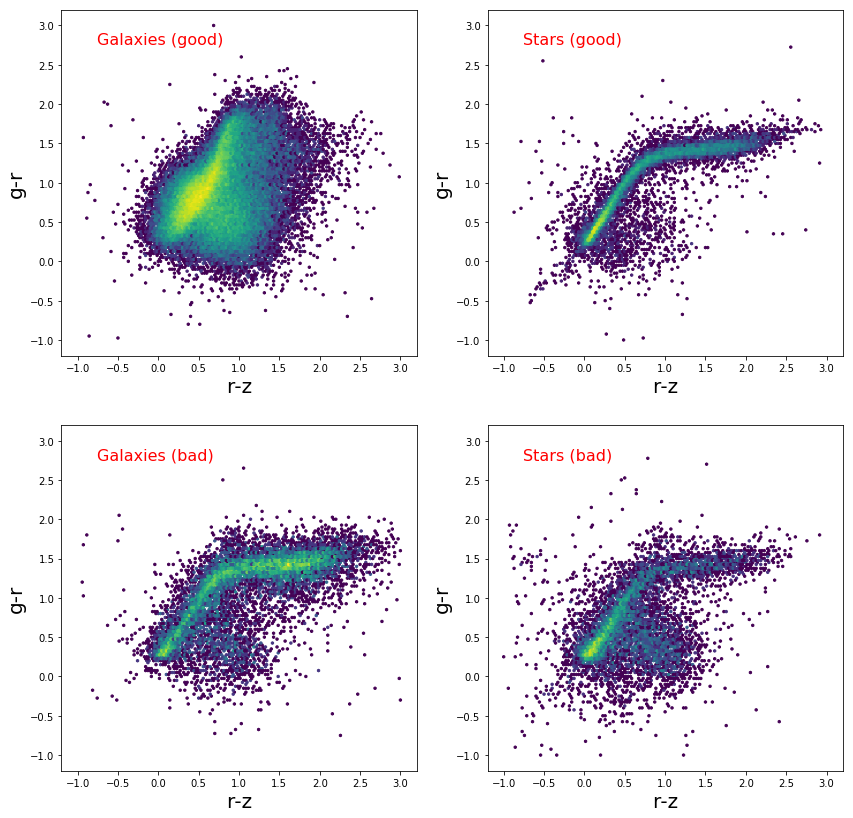

In [49]:
fig = plt.figure(figsize=(7*2,7*2))

plot_grz(df_gal,0,label='Galaxies (good)')
plot_grz(df_star,1,label='Stars (good)')
plot_grz(df_notok,2,label='Galaxies (bad)')
plot_grz(df_notok2,3,label='Stars (bad)')

outfile = 'grz_DESDR1.png'
fig.savefig(outfile, bbox_inches='tight')

The galaxy branch and the stellar locus on the g-r vs. r-z plane are much cleaner. However, it is not clear what happens to the QSO's. It could be that they are mostly in the "cloud" below the branches and most obvious in the panel labeled "Stars (bad)". This means that they would look like a star in *g* but not in either *r* or *z*. At a fixed *r-z*, QSOs would be bluer than stars in *g-r*. One could investigate with spectroscopy or templates to confirm.

## 6.4 Comparison with LS + SDSS

For reference, this is a figure with LS (DECaLS) photometry for SDSS DR13 spectral classification (comparatively bright objects).

<figure>
<img src="ls_sdss_starGalQso.jpg", align="center", width=900>
<figcaption>**Figure:** Color-color diagrams of DECaLS photometry split by SDSS spectral classes. Slightly modified version of figure by Bela Abolfathi (UC Irvine). </figcaption>
</figure>

## 6.5 DES DR1 with g<22

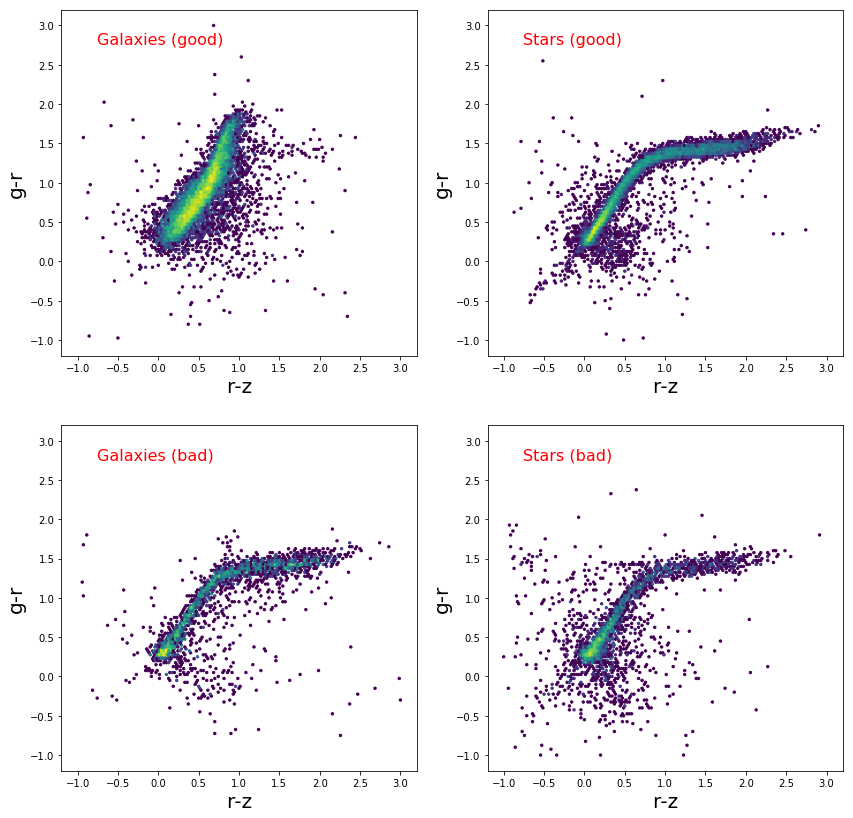

In [50]:
# Repeat above with with gmag < 22 as in SDSS/BOSS DR12Q

g22_gal    = df[(df['class_star_g']<0.5) & (df['class_star_r']<0.5) & (df['class_star_z']<0.5) & (df['gmag']<22.)]
g22_notok  = df[(df['class_star_g']<0.5) & ((df['class_star_r']>0.5) | (df['class_star_z']>0.5)) & (df['gmag']<22.)]
g22_star   = df[(df['class_star_g']>0.5) & (df['class_star_r']>0.5) & (df['class_star_z']>0.5) & (df['gmag']<22.)]
g22_notok2 = df[(df['class_star_g']>0.5) & ((df['class_star_r']<0.5) | (df['class_star_z']<0.5)) & (df['gmag']<22.)]

fig = plt.figure(figsize=(7*2,7*2))

plot_grz(g22_gal,0,label='Galaxies (good)')
plot_grz(g22_star,1,label='Stars (good)')
plot_grz(g22_notok,2,label='Galaxies (bad)')
plot_grz(g22_notok2,3,label='Stars (bad)')

outfile = 'grz_DESDR1_gLT22.png'
fig.savefig(outfile, bbox_inches='tight')


**NOTES:** In the panel above, the cloud of points near the bottom left tip of the stellar locus may include some quasars.

## 6.6 DES DR1 with g>23

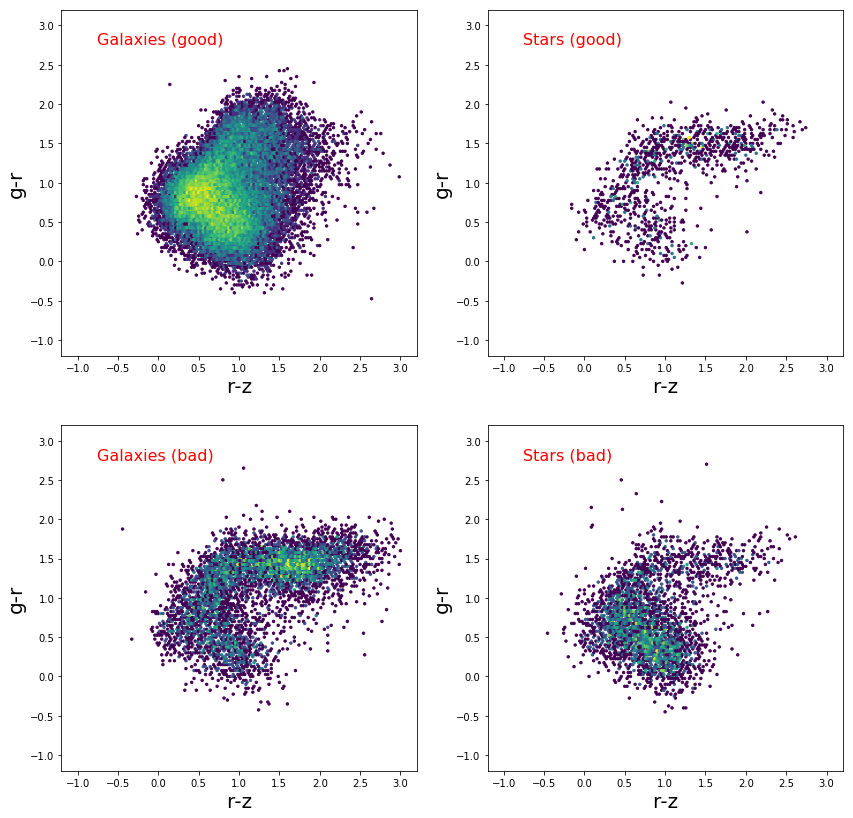

In [51]:
# Repeat above with with gmag > 23 (1 mag fainter than SDSS/BOSS DR12Q)

g23_gal    = df[(df['class_star_g']<0.5) & (df['class_star_r']<0.5) & (df['class_star_z']<0.5) & (df['gmag']>23.)]
g23_notok  = df[(df['class_star_g']<0.5) & ((df['class_star_r']>0.5) | (df['class_star_z']>0.5)) & (df['gmag']>23.)]
g23_star   = df[(df['class_star_g']>0.5) & (df['class_star_r']>0.5) & (df['class_star_z']>0.5) & (df['gmag']>23.)]
g23_notok2 = df[(df['class_star_g']>0.5) & ((df['class_star_r']<0.5) | (df['class_star_z']<0.5)) & (df['gmag']>23.)]

fig = plt.figure(figsize=(7*2,7*2))

plot_grz(g23_gal,0,label='Galaxies (good)')
plot_grz(g23_star,1,label='Stars (good)')
plot_grz(g23_notok,2,label='Galaxies (bad)')
plot_grz(g23_notok2,3,label='Stars (bad)')

outfile = 'grz_DESDR1_gGT23.png'
fig.savefig(outfile, bbox_inches='tight')

In the plot above, the stellar locus is broad and curved in a way that overlaps with galaxies. The increased scatter and increased overlap make using these colors for object identification more difficult compared to the situation for bright objects.

<a class="anchor" id="compare"></a>
# 7 Comparison with DES Team classification

This section includes notes on a possible star-galaxy classification from the DES team. Please see the DES Data Release paper for the latest definition. It could be interesting to make a direct comparison with the categories above.

**des_dr1.main** is the table that corresponds to **dr1** below:

Galaxies:

    WHERE
    dr1.WAVG_SPREAD_MODEL_I + 1.0*dr1.WAVG_SPREADERR_MODEL_I > 0.003 and
    dr1.WAVG_SPREAD_MODEL_I - 1.0*dr1.WAVG_SPREADERR_MODEL_I > 0.001 and
    dr1.WAVG_SPREAD_MODEL_I > -1 and
    dr1.IMAFLAGS_ISO_I = 0 and
    dr1.MAG_AUTO_I < 23

Stars:

    WHERE
    main.WAVG_SPREAD_MODEL_I + 3.0*main.WAVG_SPREADERR_MODEL_I < 0.005 and
    main.WAVG_SPREAD_MODEL_I > -1 and
    main.IMAFLAGS_ISO_I = 0 and
    main.MAG_AUTO_I < 21


<a class="anchor" id="classstar"></a>
# 8 Extra: Class_star Comparison

We compare, for the 4 categories defined above, the *class_star* values between *g* and *r* bands, and between *g* and *z* bands.

In [52]:
def plot_class_star_gr(df_input,i,label=None,**kwargs):
    ax = fig.add_subplot(2,4,i+1)
    ax.hexbin(df_input['class_star_r'],df_input['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(0,1,0,1.2))
    ax.set_xlabel('Class_star_r',fontsize=10)
    ax.set_ylabel('Class_star_g',fontsize=10)
    ax.tick_params(labelsize=10)
    if label is not None:
        ax.text(0.1,0.9,label,transform=ax.transAxes,fontsize=16,color='red',backgroundcolor='white')

In [53]:
def plot_class_star_gz(df_input,i,label=None,**kwargs):
    ax = fig.add_subplot(2,4,i+1)
    ax.hexbin(df_input['class_star_z'],df_input['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(0,1,0,1.2))
    ax.set_xlabel('Class_star_z',fontsize=10)
    ax.set_ylabel('Class_star_g',fontsize=10)
    ax.tick_params(labelsize=10)
    if label is not None:
        ax.text(0.1,0.9,label,transform=ax.transAxes,fontsize=16,color='red',backgroundcolor='white')

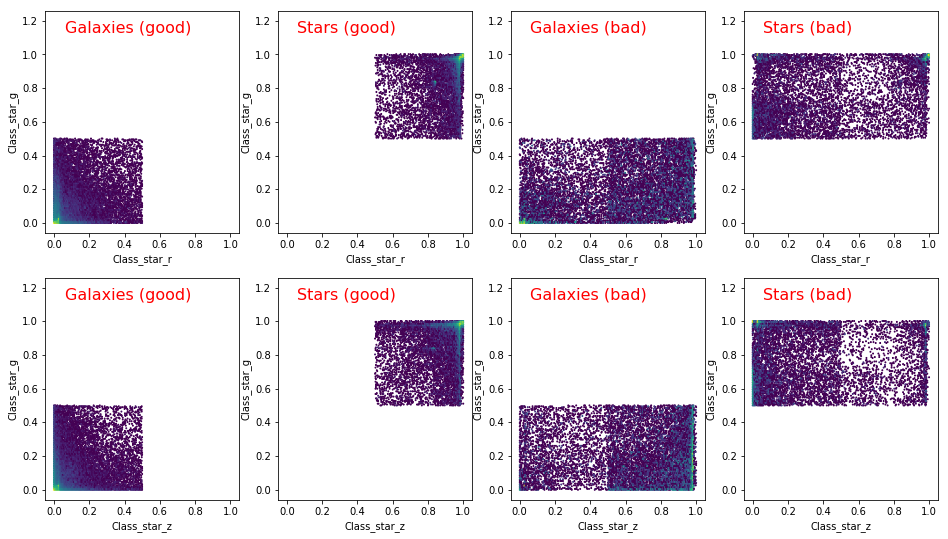

In [54]:
fig = plt.figure(figsize=(4*4,4.5*2))

plot_class_star_gr(df_gal,0,label='Galaxies (good)')
plot_class_star_gr(df_star,1,label='Stars (good)')
plot_class_star_gr(df_notok,2,label='Galaxies (bad)')
plot_class_star_gr(df_notok2,3,label='Stars (bad)')

plot_class_star_gz(df_gal,4,label='Galaxies (good)')
plot_class_star_gz(df_star,5,label='Stars (good)')
plot_class_star_gz(df_notok,6,label='Galaxies (bad)')
plot_class_star_gz(df_notok2,7,label='Stars (bad)')

outfile = 'class_star_g_COMPARE.png'
fig.savefig(outfile, bbox_inches='tight')

<a class="anchor" id="resources"></a>
# 9 References

Soumagnac et al (2015)

Desai et al (2012) 
